# Reference implementation of Deep Q-Learning

This notebook includes an implementation of the Deep Q-learning algorithm for the Cartpole problem (see [Cartpole documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/)).


## Libraries

In [15]:
!pip install gymnasium[classic-control]
!pip install "gymnasium[box2d]"
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import math

# Reproducibilidad (opcional, pero ayuda a depurar)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\motac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Hyperparameters

In [16]:
# Learning rate (más estable para LunarLander)
LEARNING_RATE = 2.5e-4

# Batch size
BATCH_SIZE = 128

# Discount factor gamma
GAMMA = 0.99

# Size of the replay memory (replay buffer)
MEMORY_SIZE = 200_000

# Warm-up: pasos mínimos antes de empezar a entrenar
WARMUP_STEPS = 10_000

# Entrenar cada N pasos de interacción (1 = cada paso)
TRAIN_EVERY = 4

# Exploración epsilon-greedy por PASOS (no por episodio)
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY_STEPS = 150_000  # lineal hasta EPSILON_END

# Target network (soft update / Polyak)
TAU = 0.005

# Máximo número de episodios de entrenamiento (se para antes si alcanza el objetivo)
MAX_EPISODES_FOR_TRAINING = 2000

# Goal score a alcanzar durante entrenamiento (media de últimos episodios)
TRAINING_GOAL = 200

# Número de episodios usados para comprobar el objetivo durante entrenamiento
EPISODES_TO_CHECK_TRAINING_GOAL = 50

# Número de episodios para evaluar al final
EPISODES_TO_EVALUATE_MODEL_PERFORMANCE = 30


## Class ReplayMemory

Memory of transitions for experience replay.

In [17]:
class ReplayMemory:

    def __init__(self, number_of_observations):
        # Replay buffer circular (ring buffer)
        self.states = np.zeros((MEMORY_SIZE, number_of_observations), dtype=np.float32)
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations), dtype=np.float32)
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE, dtype=np.float32)
        self.dones = np.zeros(MEMORY_SIZE, dtype=np.float32)  # 1.0 si done, 0.0 si no

        self.position = 0
        self.current_size = 0

    def store_transition(self, state, action, reward, state_next, done):
        self.states[self.position] = state
        self.states_next[self.position] = state_next
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.dones[self.position] = 1.0 if done else 0.0

        self.position = (self.position + 1) % MEMORY_SIZE
        self.current_size = min(self.current_size + 1, MEMORY_SIZE)

    def sample_memory(self, batch_size):
        batch = np.random.choice(self.current_size, batch_size, replace=False)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        dones = self.dones[batch]
        return states, actions, rewards, states_next, dones


## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [18]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        self.number_of_actions = int(number_of_actions)
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)

        # --- Online network (Dueling DQN) ---
        self.model = self._build_dueling_network()

        # --- Target network ---
        self.target_model = self._build_dueling_network()
        self.target_model.set_weights(self.model.get_weights())

        # Optimización estable
        self.optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=10.0)
        self.loss_fn = keras.losses.Huber()

    def _build_dueling_network(self):
        inputs = keras.layers.Input(shape=(self.number_of_observations,), dtype=tf.float32)
        x = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(inputs)
        x = keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)

        # Dueling head: V(s) y A(s,a)
        v = keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
        v = keras.layers.Dense(1, activation="linear")(v)

        a = keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
        a = keras.layers.Dense(self.number_of_actions, activation="linear")(a)

        a_mean = keras.layers.Lambda(lambda t: tf.reduce_mean(t, axis=1, keepdims=True), output_shape=(1,))(a)
        q = v + (a - a_mean)


        return keras.Model(inputs=inputs, outputs=q)

    def remember(self, state, action, reward, next_state, done):
        state = np.asarray(state, dtype=np.float32)
        next_state = np.asarray(next_state, dtype=np.float32)
        self.memory.store_transition(state, action, reward, next_state, done)

    def select(self, state, exploration_rate):
        if np.random.rand() < exploration_rate:
            return random.randrange(self.number_of_actions)
        state = np.asarray(state, dtype=np.float32)[None, :]
        q_values = self.model(state, training=False).numpy()[0]
        return int(np.argmax(q_values))

    def select_greedy_policy(self, state):
        state = np.asarray(state, dtype=np.float32)[None, :]
        q_values = self.model(state, training=False).numpy()[0]
        return int(np.argmax(q_values))

    def _soft_update_target(self):
        # Polyak averaging: target = (1-tau)*target + tau*online
        for target_var, var in zip(self.target_model.trainable_variables, self.model.trainable_variables):
            target_var.assign((1.0 - TAU) * target_var + TAU * var)

    def learn(self):
        # Learn using Double DQN + Target network
        if self.memory.current_size < BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones = self.memory.sample_memory(BATCH_SIZE)

        states_t = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states_t = tf.convert_to_tensor(next_states, dtype=tf.float32)
        actions_t = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards_t = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones_t = tf.convert_to_tensor(dones, dtype=tf.float32)

        # Double DQN target
        next_q_online = self.model(next_states_t, training=False)
        next_actions = tf.argmax(next_q_online, axis=1, output_type=tf.int32)

        next_q_target = self.target_model(next_states_t, training=False)
        next_idx = tf.stack([tf.range(BATCH_SIZE, dtype=tf.int32), next_actions], axis=1)
        next_q = tf.gather_nd(next_q_target, next_idx)

        targets = rewards_t + GAMMA * (1.0 - dones_t) * next_q

        with tf.GradientTape() as tape:
            q_values = self.model(states_t, training=True)
            idx = tf.stack([tf.range(BATCH_SIZE, dtype=tf.int32), actions_t], axis=1)
            q_sa = tf.gather_nd(q_values, idx)
            loss = self.loss_fn(targets, q_sa)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self._soft_update_target()

    def add_score(self, score):
        self.scores.append(score)

    def delete_scores(self):
        self.scores = []

    def average_score(self, number_of_episodes):
        index = len(self.scores) - number_of_episodes
        return float(np.mean(self.scores[max(0, index):]))

    def display_scores_graphically(self):
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.title("Training score evolution")

    def save_model(self):
        self.model.save('my_model.keras')


## Auxiliary function

In [19]:
def print_time(time):
    min = round(time // 60)
    sec = round(time % 60)
    if min > 0:
        print(f"{min} min {sec} seconds")
    else:
        print(f"{sec} seconds")

## Environment

In [20]:
def create_environment(render_mode=None):
    # Create simulated environment
    environment = gym.make("LunarLander-v3", render_mode=render_mode)
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions


## Program for training

Episode    1: score -197.62 (epsilon: 1.000, avg(last 50): -197.62, buffer: 81, steps: 81)
Episode    2: score -175.13 (epsilon: 1.000, avg(last 50): -186.37, buffer: 192, steps: 192)
Episode    3: score -127.37 (epsilon: 1.000, avg(last 50): -166.71, buffer: 272, steps: 272)
Episode    4: score  -60.63 (epsilon: 1.000, avg(last 50): -140.19, buffer: 338, steps: 338)
Episode    5: score -393.71 (epsilon: 1.000, avg(last 50): -190.89, buffer: 465, steps: 465)
Episode    6: score -195.62 (epsilon: 1.000, avg(last 50): -191.68, buffer: 541, steps: 541)
Episode    7: score -315.52 (epsilon: 1.000, avg(last 50): -209.37, buffer: 654, steps: 654)
Episode    8: score -108.86 (epsilon: 1.000, avg(last 50): -196.81, buffer: 718, steps: 718)
Episode    9: score -201.87 (epsilon: 1.000, avg(last 50): -197.37, buffer: 839, steps: 839)
Episode   10: score -118.69 (epsilon: 1.000, avg(last 50): -189.5, buffer: 901, steps: 901)
Episode   11: score -105.41 (epsilon: 1.000, avg(last 50): -181.86, buffe

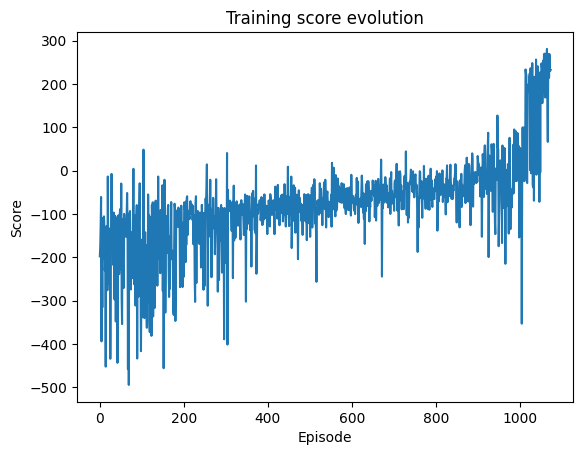

In [ ]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)

episode = 0
start_time = time.perf_counter()
total_steps = 0
goal_reached = False

def epsilon_by_step(step):
    if step < WARMUP_STEPS:
        return 1.0
    step2 = step - WARMUP_STEPS
    decay = (EPSILON_START - EPSILON_END) / EPSILON_DECAY_STEPS
    return max(EPSILON_END, EPSILON_START - decay * step2)

def evaluate_greedy(agent, env, n_episodes=10):
    scores = []
    for i in range(n_episodes):
        s, _ = env.reset()  # sin seed fijo
        done = False
        total = 0.0
        while not done:
            a = agent.select_greedy_policy(s)
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total += r
        scores.append(total)
    return float(np.mean(scores))



while (episode < MAX_EPISODES_FOR_TRAINING) and not(goal_reached):
    episode += 1
    score = 0.0
    state, info = environment.reset(seed=SEED + episode)
    done = False

    while not done:
        exploration_rate = epsilon_by_step(total_steps)
        action = agent.select(state, exploration_rate)

        state_next, reward, terminated, truncated, info = environment.step(action)
        done = terminated or truncated

        total_steps += 1

        agent.remember(state, action, reward, state_next, done)
        score += reward

        if (total_steps >= WARMUP_STEPS) and (total_steps % TRAIN_EVERY == 0):
            agent.learn()

        state = state_next

    agent.add_score(score)
    average_score = agent.average_score(EPISODES_TO_CHECK_TRAINING_GOAL)

    print("Episode {0:>4}: ".format(episode), end='')
    print("score {0:>7} ".format(round(score, 2)), end='')
    print("(epsilon: %.3f, " % epsilon_by_step(total_steps), end='')
    print("avg(last {0}): {1:>6}, ".format(EPISODES_TO_CHECK_TRAINING_GOAL, round(average_score, 2)), end='')
    print("buffer: " + str(agent.memory.current_size) + ", steps: " + str(total_steps) + ")")


    if episode % 25 == 0:
        greedy_mean = evaluate_greedy(agent, environment, n_episodes=10)
        print(f"   >> Greedy eval (10 eps): {greedy_mean:.2f}")

        if greedy_mean > getattr(agent, "best_greedy", -1e9):
            agent.best_greedy = greedy_mean
            agent.model.save("best_model.keras")

        # criterio de parada REAL (el que importa para la práctica)
        if greedy_mean >= TRAINING_GOAL:
            print("✅ Stop: greedy_mean >= 200")
            goal_reached = True


    if (episode >= EPISODES_TO_CHECK_TRAINING_GOAL) and (average_score >= TRAINING_GOAL):
        goal_reached = True

print("Time for training: ", end='')
print_time(time.perf_counter() - start_time)
print("Total steps: ", total_steps)
print("Score (average last episodes):", round(average_score, 2))
print("Score (max):", round(max(agent.scores), 2))

agent.display_scores_graphically()
agent.model.save("last_model.keras")



## Testing program



In [24]:
agent.delete_scores()
episode = 0
start_time = time.perf_counter()
while (episode < EPISODES_TO_EVALUATE_MODEL_PERFORMANCE):
    episode += 1
    score = 0
    state, info = environment.reset()
    end_episode = False
    while not(end_episode):
        # Select an action for the current state
        action = agent.select_greedy_policy(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)

        score += reward

        # Detect end of episode and print
        if terminal_state or truncated:
            agent.add_score(score)
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} \n".format(round(score)), end = '')
            end_episode = True
        else:
            state = state_next

print("Time for testing: ", end = '')
print_time(time.perf_counter() - start_time)
print("Score (average):", round(np.mean(agent.scores)))
print("Score (max):", round(max(agent.scores)))

Episode   1: score -48 
Episode   2: score 261 
Episode   3: score 227 
Episode   4: score 253 
Episode   5: score 237 
Episode   6: score 226 
Episode   7: score 262 
Episode   8: score 266 
Episode   9: score 136 
Episode  10: score 269 
Episode  11: score 252 
Episode  12: score -28 
Episode  13: score 207 
Episode  14: score 203 
Episode  15: score 203 
Episode  16: score 247 
Episode  17: score 267 
Episode  18: score   1 
Episode  19: score 284 
Episode  20: score 263 
Episode  21: score 192 
Episode  22: score 229 
Episode  23: score 245 
Episode  24: score 220 
Episode  25: score 262 
Episode  26: score 260 
Episode  27: score 255 
Episode  28: score 182 
Episode  29: score 216 
Episode  30: score 254 
Time for testing: 1 min 0 seconds
Score (average): 210
Score (max): 284
